# Lesson 4: JIT-compilation with Numba and JAX

Let's consider the following quadratic formula:

```python
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
```



What does this computation do? It gets more clear if we write this computation out:

```python
def pedantic_quadratic_formula(a, b, c):
    tmp1 = np.negative(b)            # -b
    tmp2 = np.square(b)              # b**2
    tmp3 = np.multiply(4, a)         # 4*a
    tmp4 = np.multiply(tmp3, c)      # tmp3*c
    del tmp3
    tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
    del tmp2, tmp4
    tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
    del tmp5
    tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
    del tmp1, tmp6
    tmp8 = np.multiply(2, a)         # 2*a
    return np.divide(tmp7, tmp8)     # tmp7 / tmp8
```



There are **9(!)** elementwise operations that each runs a compiled loop, i.e.:

```python
tmp1 = np.negative(b)  
tmp2 = np.square(b)
...

# is equivalent to
n = len(b)
tmp1 = np.empty(n)
for i in range(n):  # (compiled loop)
    tmp1[i] = -b[i]

tmp2 = np.empty(n)
for i in range(n):  # (compiled loop)
    tmp2[i] = b[i] ** 2

...
```



It would be much more efficient to apply all elementwise operations in a single loop:
```python
n = len(b)
out = np.empty(n)
for i in range(n):  # (compiled loop)
    out[i] = (-b[i] + np.sqrt(b[i]**2 - 4*a[i]*c[i])) / (2*a[i])
```

Let's do that in C:

In [1]:
%%writefile code/quadratic_formula_c.c

#include <math.h>

void run(double* a, double* b, double* c, double* output) {
    for (int i = 0;  i < 10000000;  i++) {
        output[i] = (-b[i] + sqrt(b[i]*b[i] - 4*a[i]*c[i])) / (2*a[i]);
    }
}

Writing code/quadratic_formula_c.c


In [2]:
# compile
!cc code/quadratic_formula_c.c -shared -lm -o code/quadratic_formula_c.so

In [3]:
# python bindings
import ctypes

quadratic_formula_c = ctypes.CDLL("code/quadratic_formula_c.so")
quadratic_formula_c.run.argtypes = (ctypes.POINTER(ctypes.c_double),) * 4
quadratic_formula_c.run.restype = None

In [4]:
# allocate inputs and an output to write into
import numpy as np

a = np.random.uniform(5, 10, 10000000)
b = np.random.uniform(10, 20, 10000000)
c = np.random.uniform(-0.1, 0.1, 10000000)
output = np.zeros(10000000, dtype=np.float64)

def prepare_args(a, b, c, output):
    return [arg.ctypes.data_as(ctypes.POINTER(ctypes.c_double)) for arg in (a, b, c, output)]

In [5]:
pointers = prepare_args(a, b, c, output)
quadratic_formula_c.run(*pointers)
print(output)

[-0.00278288  0.00376064 -0.00274397 ... -0.00677038 -0.00422018
  0.00536392]


In [6]:
%%timeit
quadratic_formula_c.run(*pointers)

21.3 ms ± 133 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
# compared to numpy

(-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

37.3 ms ± 588 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


NumPy allocated intermediate array for each operation as shown in `pedantic_quadratic_formula`.

By _fusing_ those operations, we're able to get rid of _intermediate_ arrays using just-in-time (JIT) compilation by applying these operations in a _single_ iteration over our data.

Fusing operations is a tricky task however (if you do not want to do this manually with C/C++). There are a few ways to achieve this for array processing in Python, and I'd like to highlight two of them:

- Numba: https://numba.pydata.org
- JAX: https://github.com/jax-ml/jax

In [8]:
# NumPy
import numpy as np

# JAX
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

# Numba
import numba as nb

# Matplotlib
import matplotlib.pyplot as plt

Let's consider the quadratic formula example again, and compare the runtimes for NumPy, Numba, and JAX:

In [9]:
# Setup data
a = np.random.uniform(5, 10, 5_000_000)
b = np.random.uniform(10, 20, 5_000_000)
c = np.random.uniform(-0.1, 0.1, 5_000_000)


# Setup quadratic formula
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

NumPy case:

In [10]:
%%timeit -n1 -r3

quadratic_formula(a, b, c)

23 ms ± 1.34 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Numba case:

In [11]:
@nb.njit  # JIT compile!
def quadratic_formula_numba(a, b, c):
    n = a.shape[0]
    out = np.empty(n)
    for i in range(n):
        out[i] = (-b[i] + np.sqrt(b[i]**2 - 4*a[i]*c[i])) / (2*a[i])
    return out

In [12]:
%%timeit -n1

quadratic_formula_numba(a, b, c)

The slowest run took 121.03 times longer than the fastest. This could mean that an intermediate result is being cached.
116 ms ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit -n10 -r3

quadratic_formula_numba(a, b, c)

7.34 ms ± 296 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


JAX case:

In [14]:
# Setup data
a_jax = jnp.asarray(a)
b_jax = jnp.asarray(b)
c_jax = jnp.asarray(c)


@jax.jit  # JIT compile!
def quadratic_formula_jax(a, b, c):
    return (-b + jnp.sqrt(b**2 - 4*a*c)) / (2*a)

In [15]:
%%timeit -n1

quadratic_formula_jax(a_jax, b_jax, c_jax).block_until_ready()

The slowest run took 17.48 times longer than the fastest. This could mean that an intermediate result is being cached.
7.22 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit -n10 -r3

quadratic_formula_jax(a_jax, b_jax, c_jax).block_until_ready()

2.76 ms ± 111 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


The first invocation for JAX & Numba took longer than consecutive ones. That's the compile time! Afterwards the compiled function is cached...

But JAX is still much faster, why?

One important difference is that JAX uses as many threads as it has access to. Numba is single-threaded, but can be multithreaded using `parallel=True`:

In [17]:
@nb.njit(parallel=True)  # JIT compile with `parallel=True`!
def quadratic_formula_numba_parallel(a, b, c):
    n = a.shape[0]
    out = np.empty(n)
    for i in nb.prange(n):  # note: `range` -> `nb.prange`
        out[i] = (-b[i] + np.sqrt(b[i]**2 - 4*a[i]*c[i])) / (2*a[i])
    return out

In [18]:
%%timeit -n1

quadratic_formula_numba_parallel(a, b, c)

The slowest run took 86.34 times longer than the fastest. This could mean that an intermediate result is being cached.
26.7 ms ± 60.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [19]:
%%timeit -n10 -r3

quadratic_formula_numba_parallel(a, b, c)

2.68 ms ± 450 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


Now we're roughly on-par with JAX and Numba with ~2-3ms runtime compared to NumPy's ~23ms.


You might have noticed a fundamental difference between JAX and Numba in how those kernels are written: 

- Numba forces[<sup id="fn1-back">1</sup>](#fn1) you to write _imperative_ code
- JAX forces[<sup id="fn2-back">2</sup>](#fn2) you to write _array-oriented_ code


![image](https://raw.githubusercontent.com/jpivarski-talks/2023-12-18-hsf-india-tutorial-bhubaneswar/refs/heads/main/img/slow-fast-imperative-vectorized.svg)



[<sup id="fn1">1</sup>](#fn1-back) <sup>Can be written array-oriented with `nb.vectorize`.</sup> 

[<sup id="fn2">2</sup>](#fn2-back) <sup>Can be written imperative with JAX's own loop primitives, e.g. `jax.lax.scan`.</sup>

### How does JIT compilation even work? (JAX)

Let's have a look at the JAX example, what does `jax.jit` do?

It works in 4 steps:
1. Stage out a `jax.jit`-decorated function into a new program using a JAX internal IR (JaxPr)
2. Lower this IR (JaxPr) into the StableHLO IR
3. Compile the StableHLO program with the XLA compiler
4. Execute the compiled program

Let's see those 4 steps in action:

In [20]:
# Step 1: Create the JaxPr (through tracing)
traced = quadratic_formula_jax.trace(a_jax, b_jax, c_jax)
print(traced.jaxpr)

{ lambda ; a:f64[5000000] b:f64[5000000] c:f64[5000000]. let
    d:f64[5000000] = neg b
    e:f64[5000000] = integer_pow[y=2] b
    f:f64[5000000] = mul 4.0:f64[] a
    g:f64[5000000] = mul f c
    h:f64[5000000] = sub e g
    i:f64[5000000] = sqrt h
    j:f64[5000000] = add d i
    k:f64[5000000] = mul 2.0:f64[] a
    l:f64[5000000] = div j k
  in (l,) }


This JaxPr looks a lot like the previously shown pedantic version of the quadratic formula (lecture part-2):

```python
def pedantic_quadratic_formula(a, b, c):
    tmp1 = np.negative(b)            # -b
    tmp2 = np.square(b)              # b**2
    tmp3 = np.multiply(4, a)         # 4*a
    tmp4 = np.multiply(tmp3, c)      # tmp3*c
    del tmp3
    tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
    del tmp2, tmp4
    tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
    del tmp5
    tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
    del tmp1, tmp6
    tmp8 = np.multiply(2, a)         # 2*a
    return np.divide(tmp7, tmp8)     # tmp7 / tmp8
```

But instead of executing line-by-line we'll lower our JaxPr to StableHLO, and then compile it with XLA to fuse those kernels!

In [21]:
# Step 2: Lower the JaxPr to StableHLO (still looks similar to our pedantic code)
lowered = quadratic_formula_jax.lower(a_jax, b_jax, c_jax)
print(lowered.as_text())

module @jit_quadratic_formula_jax attributes {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32} {
  func.func public @main(%arg0: tensor<5000000xf64>, %arg1: tensor<5000000xf64>, %arg2: tensor<5000000xf64>) -> (tensor<5000000xf64> {jax.result_info = "result"}) {
    %0 = stablehlo.negate %arg1 : tensor<5000000xf64>
    %1 = stablehlo.multiply %arg1, %arg1 : tensor<5000000xf64>
    %cst = stablehlo.constant dense<4.000000e+00> : tensor<f64>
    %2 = stablehlo.broadcast_in_dim %cst, dims = [] : (tensor<f64>) -> tensor<5000000xf64>
    %3 = stablehlo.multiply %2, %arg0 : tensor<5000000xf64>
    %4 = stablehlo.multiply %3, %arg2 : tensor<5000000xf64>
    %5 = stablehlo.subtract %1, %4 : tensor<5000000xf64>
    %6 = stablehlo.sqrt %5 : tensor<5000000xf64>
    %7 = stablehlo.add %0, %6 : tensor<5000000xf64>
    %cst_0 = stablehlo.constant dense<2.000000e+00> : tensor<f64>
    %8 = stablehlo.broadcast_in_dim %cst_0, dims = [] : (tensor<f64>) -> tensor<5000000xf64>
    %9 = stablehlo

In [22]:
# Step 3: Compile the StableHLO program with XLA
compiled = lowered.compile()
# print(compiled.as_text())

In [23]:
# Step 4: Execute the compiled program
print(compiled(a_jax, b_jax, c_jax))

[-0.00381363 -0.00280112  0.00486536 ... -0.00351526  0.0013406
 -0.00051469]


### Limitations of Numba

You can not JIT-compile arbitrary Python functions. Numba can only JIT-compile a subset of Python, i.e. everything that's "known" to Numba as a type (mostly NumPy & NumPy operations).

For more information, see: https://numba.readthedocs.io/en/stable/user/5minguide.html#will-numba-work-for-my-code.


Check the following:

In [24]:
@nb.njit
def sum_dict_values(d):
    out = 0.
    for v in d.values():
        out += v
    return out

sum_dict_values({"a": 1.0, "b": 2.0, "c": 3.0})  # Fails, because `dict` is not a known type for Numba

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /var/folders/34/_lhgt3t51_d5yqwccswc8k9w0000gn/T/ipykernel_95170/463706393.py (1)

File "../../../../../../../var/folders/34/_lhgt3t51_d5yqwccswc8k9w0000gn/T/ipykernel_95170/463706393.py", line 1:
<source missing, REPL/exec in use?>

During: Pass nopython_type_inference 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'dict'>


### Limitations of JAX

JAX infers the operations that are going to be run through a "tracing step". Essentially, JAX will run your program once with shallow array objects (no data, just metadata). That let's you JIT-compile all of Python, **but** you can't JIT-compile data-dependent operations.

For more "sharp bits", see: https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html.

Check the following:

In [25]:
# Data-dependent operations are not traceable

@jax.jit
def accumulate_if(arr):
    print(arr)
    if jnp.any(arr > 3):
        return jnp.sum(arr)
    else:
        return jnp.prod(arr)


array = jnp.array([1., 2., 3., 4., 5.])
print(accumulate_if(array))  # Fails, because jnp.any(arr > 3) is not traceable!

JitTracer<float64[5]>


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function accumulate_if at /var/folders/34/_lhgt3t51_d5yqwccswc8k9w0000gn/T/ipykernel_95170/3495820511.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument arr.
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

Another limitation of JAX is that you can't JIT compile programs with unknown shapes:

In [26]:
@jax.jit
def sum_greater_than_three(arr):
    return jnp.sum(arr[arr > 3.0])


array = jnp.array([1., 2., 3., 4., 5.])
print(sum_greater_than_three(array))  # Fails, because the output shape of `arr[arr > 3.0]` is not inferrable through tracing (without data)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got bool[5]

See https://docs.jax.dev/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

### Impure functions are dangerous with JIT compilation! (Numba & JAX)

In [27]:
do_sum = False

@nb.njit
def accumulate(arr):
    if do_sum:
        return np.sum(arr)
    else:
        return np.prod(arr)


array = np.array([1., 2., 3., 4., 5.])
print("Accumulate with `np.prod`:", accumulate(array))

# now we switch `do_sum` on!
do_sum = True
print("Accumulate with `np.sum`:", accumulate(array), f"...Hey, this should've been {np.sum(array)} instead!")

Accumulate with `np.prod`: 120.0
Accumulate with `np.sum`: 120.0 ...Hey, this should've been 15.0 instead!


In [28]:
do_sum = False

@jax.jit
def accumulate(arr):
    if do_sum:
        return jnp.sum(arr)
    else:
        return jnp.prod(arr)


array = jnp.array([1., 2., 3., 4., 5.])

print("Accumulate with `jnp.prod`:", accumulate(array))

# now we switch `do_sum` on!
do_sum = True
print("Accumulate with `jnp.sum`:", accumulate(array), f"...Hey, this should've been {jnp.sum(array)} instead!")

Accumulate with `jnp.prod`: 120.0
Accumulate with `jnp.sum`: 120.0 ...Hey, this should've been 15.0 instead!


We can see why in the JAX case: that's because the traced program _never knew_ that there's a `sum` operation in the first place _and_ the compiled function is cached based on their input arguments.

In [29]:
print("Traced program:\n", accumulate.trace(array).jaxpr)
print()
print("HLO program:\n", accumulate.lower(array).as_text()) # this is the program that get's compiled by XLA compiler

Traced program:
 { lambda ; a:f64[5]. let b:f64[] = reduce_prod[axes=(0,)] a in (b,) }

HLO program:
 module @jit_accumulate attributes {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32} {
  func.func public @main(%arg0: tensor<5xf64>) -> (tensor<f64> {jax.result_info = "result"}) {
    %cst = stablehlo.constant dense<1.000000e+00> : tensor<f64>
    %0 = stablehlo.reduce(%arg0 init: %cst) applies stablehlo.multiply across dimensions = [0] : (tensor<5xf64>, tensor<f64>) -> tensor<f64>
    return %0 : tensor<f64>
  }
}



On to the [project.ipynb](project.ipynb)!

### Auto-differentiation with JAX


Knowing the computational graph of a program (i.e. JaxPr) gives us the possibility to transform the program. JAX implements different _interpreters_ to execute the JaxPr of which one is able to replace every operation by its gradient:


In [30]:
def fun(x):
    return 2.0 + jnp.sin(x)

print("JaxPr:")
print(jax.make_jaxpr(fun)(1.0))
print()

grad_fun = jax.grad(fun)
print("JaxPr (grad):")
print(jax.make_jaxpr(grad_fun)(1.0))

JaxPr:
{ lambda ; a:f64[]. let b:f64[] = sin a; c:f64[] = add 2.0:f64[] b in (c,) }

JaxPr (grad):
{ lambda ; a:f64[]. let
    b:f64[] = sin a
    c:f64[] = cos a
    _:f64[] = add 2.0:f64[] b
    d:f64[] = mul 1.0:f64[] c
  in (d,) }


Gradients are powerful! Many scientific problems involve gradient-based minimizations.

Let's implement a gradient-based optimization on our own:

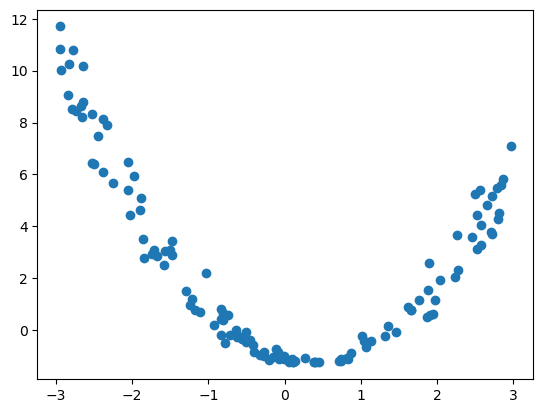

In [31]:
rng = jax.random.key(42)

true_a, true_b = 0.2, 1.1

# function that we want to fit
@jax.jit
def function(x, a, b):
    return b*x**2 - 4*a*x - b

# generate true data with some noise
def generate_data(rng):
    x_key, noise_key = jax.random.split(rng)

    xs = jax.random.uniform(x_key, (128, 1), minval=-3, maxval=3)
    noise = jax.random.normal(noise_key, (128, 1)) * 0.15

    ys = function(x=xs + noise, a=true_a, b=true_b)
    return xs, ys


# plot data
xs, ys = generate_data(rng=rng)
plt.scatter(xs, ys)

We want to know what the true underlying `a` and `b` values are in this distribution. The next cell implements a gradient-based optimization to fit `function` to the distribution:

True parameters  : a=0.20, b=1.10
Fitted parameters: a=0.20, b=1.09


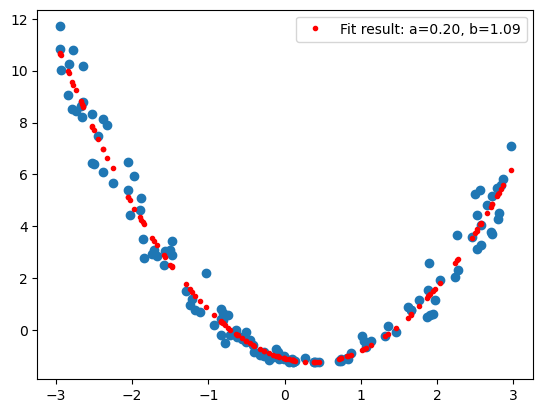

In [32]:
from typing import NamedTuple


# Just a struct that holds the parameters of the function
class Params(NamedTuple):
    a: jax.Array
    b: jax.Array


# Initialize parameters for the function (`a` and `b`)
def init(rng) -> Params:
    a_key, b_key = jax.random.split(rng)
    a = jax.random.normal(a_key, ())
    b = jax.random.normal(b_key, ())
    return Params(a, b)


# Compute the loss function (least squares error)
def loss(params: Params, x: jax.Array, y: jax.Array) -> jax.Array:
    pred = function(x=x, a=params.a, b=params.b)
    return jnp.mean((pred - y) ** 2)


# Perform one gradient descent update step on params using the given data. (~SGD)
@jax.jit
def update(params: Params, x: jax.Array, y: jax.Array) -> Params:
    # Computes the gradients of the loss function with respect to the parameters
    grads = jax.grad(loss)(params, x, y)

    # Define a step function that updates the parameters
    def step(param, grad):
      return param - 0.005 * grad  # 0.005 := learning rate

    # Apply the step function to each parameter
    return jax.tree.map(step, params, grads)


# Run the optimization
params = init(rng)
for _ in range(500):
    params = update(params, xs, ys)


print(f"True parameters  : a={true_a:.2f}, b={true_b:.2f}")
print(f"Fitted parameters: a={params.a:.2f}, b={params.b:.2f}")

plt.scatter(xs, ys)
pred_ys = function(x=xs, a=params.a, b=params.b)
plt.plot(xs, pred_ys, ".", c='red', label=f'Fit result: a={params.a:.2f}, b={params.b:.2f}')
plt.legend()

This is the key ingredient for training neural networks, see more at the next ML lecture by Michelle!